In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir 
import muon as mu

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


In [3]:
mdata = mu.read("/Users/jerryaaaaaa/scTCR_merged_res0.2.h5mu")

/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


In [4]:
mdata

MuData object with n_obs × n_vars = 4899 × 21941
  2 modalities
    gex:	4899 x 21941
      obs:	'n_genes', 'leiden'
      var:	'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'scaled'
      obsp:	'connectivities', 'distances'
    airr:	4899 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'chain_indices', 'clone_id', 'clonotype_network', 'ir_dist_nt_identity', 'scirpy_version'
      obsm:	'X_clonotype_network', 'airr', 'chain_indices'

T-cell clonotype definition (cells >= 2)

In [20]:
#Identify frequent T-cell clone
clone_counts = mdata["airr"].obs["clone_id"].value_counts()
frequent_clones = clone_counts[clone_counts >= 2].index.tolist()

In [21]:
#Subset data
mdata_filtered = mdata[mdata["airr"].obs["clone_id"].isin(frequent_clones)].copy()

In [22]:
mdata_filtered

MuData object with n_obs × n_vars = 4686 × 21941
  2 modalities
    gex:	4686 x 21941
      obs:	'n_genes', 'leiden'
      var:	'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'scaled'
      obsp:	'connectivities', 'distances'
    airr:	4686 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'chain_indices', 'clone_id', 'clonotype_network', 'ir_dist_nt_identity', 'scirpy_version'
      obsm:	'X_clonotype_network', 'airr', 'chain_indices'

In [23]:
cdr3_info = ir.get.airr(
    mdata_filtered["airr"],
    airr_variable=["cdr3_aa"],
    chain=["VJ_1", "VDJ_1"]
)
clone_info = mdata_filtered["airr"].obs[["clone_id", "clone_id_size"]].copy()
tcr_info = clone_info.join(cdr3_info, how="inner")

In [24]:
tcr_info.reset_index(inplace=True)

In [25]:
tcr_info

,cell_id,clone_id,clone_id_size,VJ_1_cdr3_aa,VDJ_1_cdr3_aa
0,AAACCTGAGAATGTTG-1,0,2879,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY
1,AAACCTGAGGTAGCTG-1,0,2879,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY
2,AAACCTGAGTAGATGT-1,1,219,APLGNEKLT,ASSYYRPTGPYEQY
3,AAACCTGAGTGGAGTC-1,0,2879,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY
4,AAACCTGCAGACAAGC-1,0,2879,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY
...,...,...,...,...,...
4681,TTTGTCACATCGACGC-1,0,2879,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY
4682,TTTGTCAGTTGGAGGT-1,0,2879,AMPVVDLLTGGADGLT,ASSVEPQLAGRGDTQY
4683,TTTGTCATCACAACGT-1,111,12,ATVPMFSGGYNKLI,ASTLLRGEQF
4684,TTTGTCATCCAAATGC-1,3,172,ATQLYNARLM,ASSARGTKNIQY


In [26]:
tcr_per_clone = (
    tcr_info.groupby("clone_id")[["clone_id_size", "VDJ_1_cdr3_aa"]]
    .agg(lambda x: x.value_counts().index[0])
    .reset_index()
)

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_97354/1398339022.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tcr_info.groupby("clone_id")[["clone_id_size", "VDJ_1_cdr3_aa"]]


In [27]:
tcr_per_clone

,clone_id,clone_id_size,VDJ_1_cdr3_aa
0,0,2879,ASSVEPQLAGRGDTQY
1,1,219,ASSYYRPTGPYEQY
2,2,486,ASSRGQYTGELF
3,3,172,ASSARGTKNIQY
4,4,24,ASSLGLRNEQY
...,...,...,...
100,270,3,ASSRTGLGPDTQY
101,280,2,ASSVGRGGGNTQY
102,286,2,ASSQDQDGIGAKNIQY
103,295,2,AWSVLEGRAPYEQY


In [28]:
tcr_per_clone.to_csv("/Users/jerryaaaaaa/tcr_per_clone_filtered_2.csv")

In [29]:
mdata_filtered["gex"].obs["clone_id"] = mdata_filtered["airr"].obs["clone_id"]

In [31]:
import seaborn as sns

In [39]:
clone_palette = sns.color_palette("husl", n_colors=105)

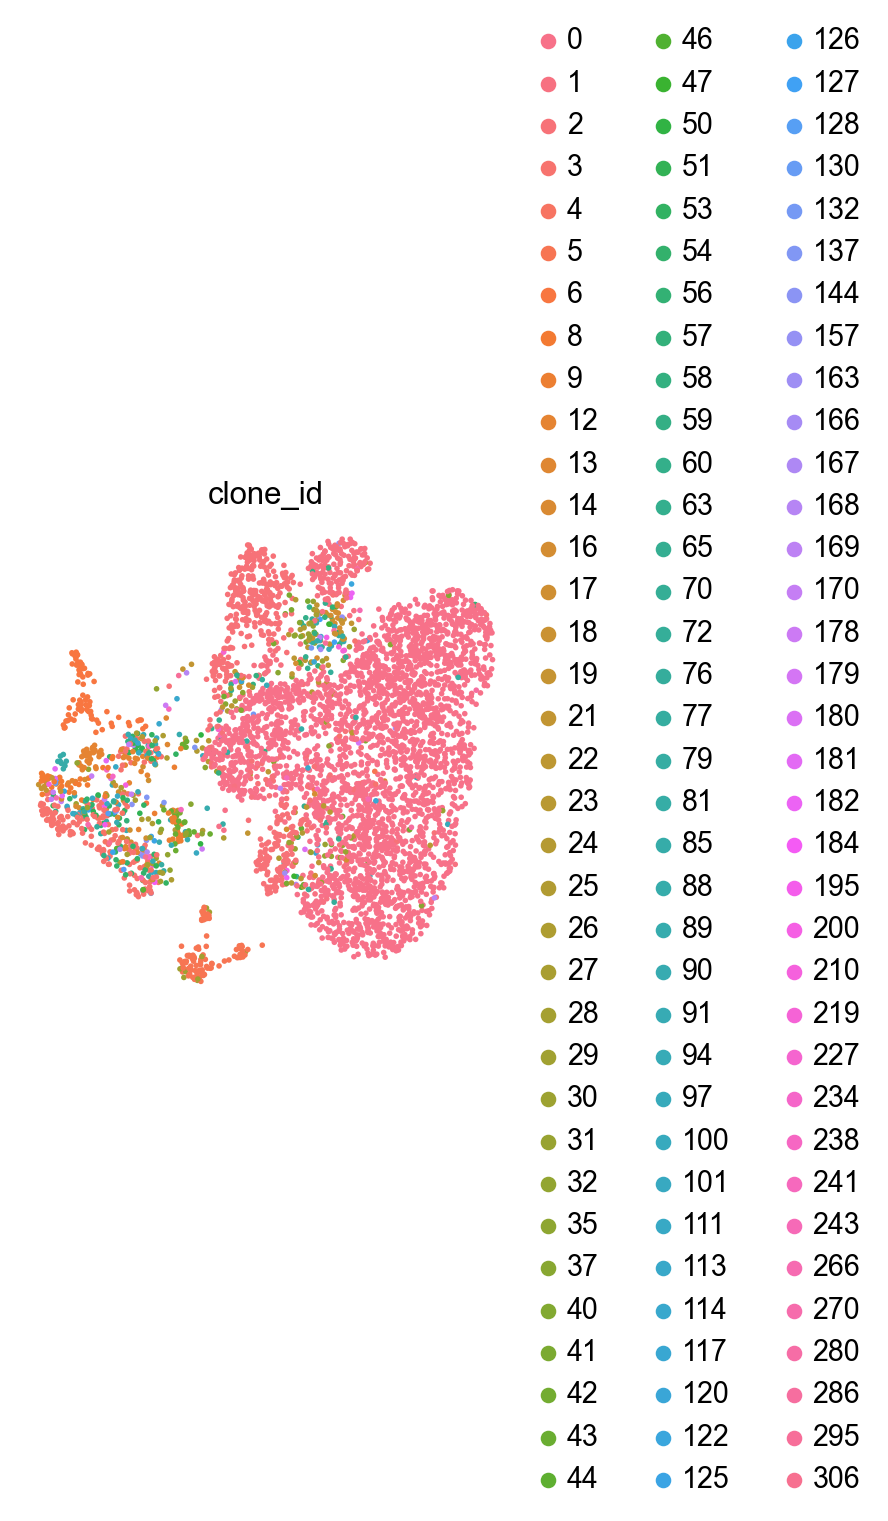

In [70]:
sc.pl.umap(mdata_filtered["gex"], color="clone_id", palette=clone_palette, frameon=False)

XGBoost Model Prediction

In [41]:
import pickle

In [42]:
with open("/Users/jerryaaaaaa/taxidermic_gex_features.pkl", "rb") as f:
    feature_genes = pickle.load(f)

In [43]:
from xgboost import XGBClassifier

In [44]:
model = XGBClassifier()
model.load_model("/Users/jerryaaaaaa/taxidermic_gex_model.json")

In [45]:
features = mdata_filtered["gex"].to_df()[feature_genes]

In [46]:
y_proba = model.predict_proba(features)[:, 1]

In [47]:
mdata_filtered["gex"].obs["predicted_reactivity_proba"] = y_proba

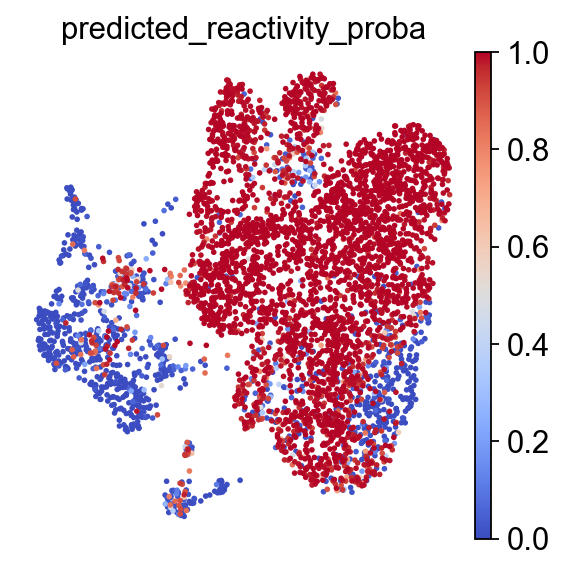

In [48]:
sc.pl.umap(mdata_filtered["gex"], color="predicted_reactivity_proba", cmap="coolwarm", frameon=False, vmax=1, vmin=0)

In [49]:
xgb_predict_df = pd.DataFrame({
    "clone_id": mdata_filtered["gex"].obs["clone_id"],
    "reactivity_proba": y_proba
})
clone_reactivity = xgb_predict_df.groupby("clone_id")["reactivity_proba"].mean()

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_97354/634522314.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clone_reactivity = xgb_predict_df.groupby("clone_id")["reactivity_proba"].mean()


In [50]:
clone_reactivity = clone_reactivity.reset_index()
clone_reactivity.columns = ["clone_id", "avg_reactivity_probability"]

In [51]:
import matplotlib.pyplot as plt

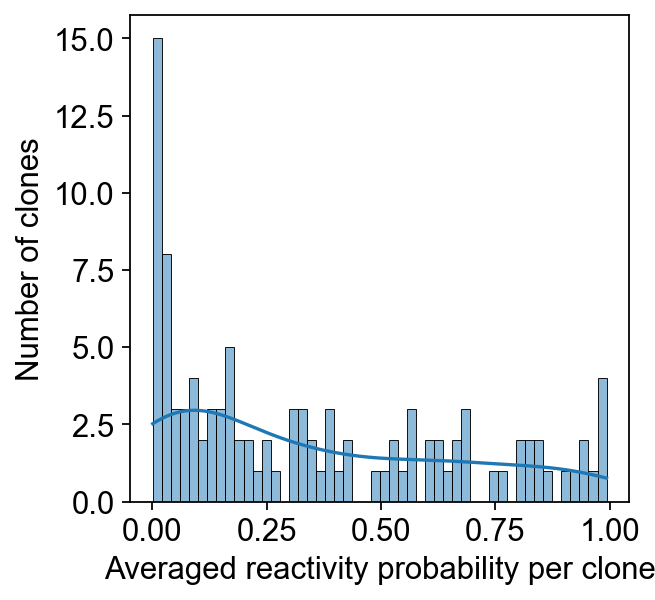

In [52]:
sns.histplot(clone_reactivity["avg_reactivity_probability"], bins=50, kde=True)
plt.xlabel("Averaged reactivity probability per clone")
plt.ylabel("Number of clones")
plt.grid(False)
plt.show()

Gaussian Mixture

In [54]:
from sklearn.mixture import GaussianMixture

In [55]:
probs = clone_reactivity["avg_reactivity_probability"].values.reshape(-1, 1)
gmm =GaussianMixture(n_components=2, random_state=42).fit(probs)

labels = gmm.predict(probs)
means = gmm.means_.flatten()
reactive_label = np.argmax(means)

reactivity_threshold = probs[labels == reactive_label].min()
print(f"GMM-derived threshold: {reactivity_threshold:.4f}")

GMM-derived threshold: 0.2100


Fisher Jenk Natural Break

In [56]:
import jenkspy

In [58]:
pred_probs = np.array(y_proba)
breaks = jenkspy.jenks_breaks(pred_probs, 2)
threshold = breaks[1]
print(f"Fisher-Jenks threshold: {threshold:.3f}")

Fisher-Jenks threshold: 0.503


In [59]:
clone_reactivity["clone_reactivity"] = clone_reactivity["avg_reactivity_probability"].apply(
    lambda x: "Reactive" if x > threshold else "Nonreactive"
)

In [60]:
clone_reactivity = clone_reactivity.set_index("clone_id")
mdata_filtered["gex"].obs["prediction"] = mdata_filtered["gex"].obs["clone_id"].map(
    clone_reactivity["clone_reactivity"]
)

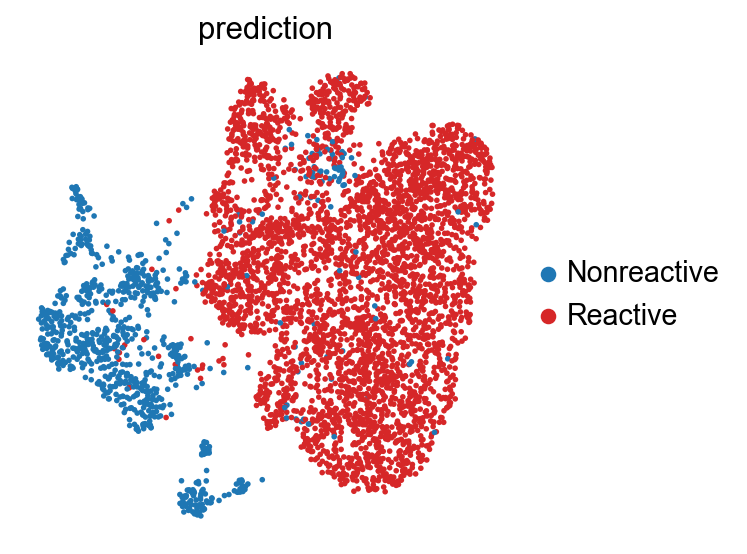

In [61]:
sc.pl.umap(mdata_filtered["gex"], color="prediction", palette=["tab:blue", "tab:red"], frameon=False)

In [62]:
clone_reactivity

,avg_reactivity_probability,clone_reactivity
clone_id,,
0,0.871669,Reactive
1,0.941441,Reactive
2,0.921375,Reactive
3,0.169375,Nonreactive
4,0.317746,Nonreactive
...,...,...
270,0.003652,Nonreactive
280,0.666872,Reactive
286,0.489638,Nonreactive


In [63]:
reactive_clones = clone_reactivity[clone_reactivity["clone_reactivity"] == "Reactive"]
n_reactive = len(reactive_clones)
print(n_reactive)

34


In [64]:
clone_counts = mdata["airr"].obs["clone_id"].value_counts()
frequent_clones = clone_counts[clone_counts >= 5].index.tolist()
mdata_filtered_2 = mdata[mdata["airr"].obs["clone_id"].isin(frequent_clones)].copy()

In [72]:
clone_reactivity.reset_index(inplace=True)
clone_reactivity

,clone_id,avg_reactivity_probability,clone_reactivity
0,0,0.871669,Reactive
1,1,0.941441,Reactive
2,2,0.921375,Reactive
3,3,0.169375,Nonreactive
4,4,0.317746,Nonreactive
...,...,...,...
100,270,0.003652,Nonreactive
101,280,0.666872,Reactive
102,286,0.489638,Nonreactive
103,295,0.529976,Reactive
